In [1]:
# general tools
import sys
from glob import glob

# data tools
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

# graph tools
import matplotlib.pyplot as plt
%matplotlib inline

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import model_utils as mu
import train_utils as tu
import graph_utils as gu

In [2]:
from importlib import reload
reload(mu)

<module 'model_utils' from '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/model_utils.py'>

# Global settings

In [3]:
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

In [4]:
sea = 'jja' # testing in the JJA season
VAR = 'TMEAN'

input_flag = [False, False, False, False, True, False]
output_flag = [False, False, False, False, True, False]
labels = ['batch', 'batch']

# Model

In [5]:
file_path = BATCH_dir
model_path = temp_dir+'DAE_{}_{}_elev.hdf'.format(VAR, sea) # model checkpoint

AE = keras.models.load_model(model_path)
W = AE.get_weights()

N = [48, 96, 192, 384]
input_size = (None, None, 1)
# DAE
DAE = mu.DAE(N, input_size)
DAE.set_weights(W)

## Model summary

## Test the model with samples 

In [6]:
trainfile = glob(BATCH_dir+'{}_BATCH_*_TORI*{}*.npy'.format(VAR, sea))
temp_data = np.load(trainfile[0], allow_pickle=True)[()]

In [7]:
X = temp_data['batch'][..., input_flag]
Y = DAE.predict(X)

In [ ]:
plt.pcolormesh(-1*temp_data['batch'][85, ..., 2], vmin=-3, vmax=3, cmap=camp_t2)
plt.title('Autoencoder input', fontsize=14)

Text(0.5, 1.0, 'Autoencoder output')

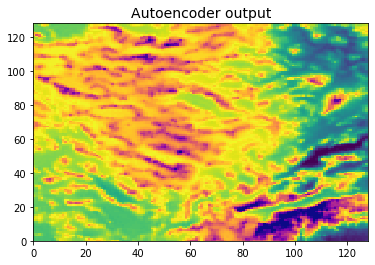

In [15]:
plt.pcolormesh(Y[85, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)
plt.title('Autoencoder output', fontsize=14)

# Perceptual loss (from encoder)

## Feature space definition

In [6]:
def loss_model(VAR, sea, layer_id):
    model_path = temp_dir+'DAE_{}_{}_self.hdf'.format(VAR, sea) # model checkpoint
    AE = keras.models.load_model(model_path)
    W = AE.get_weights()

    N = [48, 96, 192, 384]
    input_size = (None, None, 1)
    # DAE
    DAE = mu.DAE(N, input_size)
    DAE.set_weights(W)
    # freeze
    DAE.trainable = False
    for layer in DAE.layers:
        layer.trainable = False
    f_sproj = [DAE.layers[i].output for i in layer_id]
    
    loss_models = []
    for single_proj in f_sproj:
        loss_models.append(keras.models.Model(DAE.inputs, single_proj))
    return loss_models


In [7]:
layer_id = [7, 13, 19]
loss_models = loss_model(VAR, sea, layer_id)

In [8]:
def CLOSS(y_true, y_pred):
    '''
    MAE style content loss
    '''
    return 0.25*K.mean(K.abs(loss_models[0](y_true) - loss_models[0](y_pred)))+\
           0.25*K.mean(K.abs(loss_models[1](y_true) - loss_models[1](y_pred)))+\
           0.25*K.mean(K.abs(loss_models[2](y_true) - loss_models[2](y_pred)))+\
           0.25*K.mean(K.abs(y_true - y_pred))

In [9]:
def dummy_model_loader(N_input, VAR, sea):
    # model name
    model_name = 'UNET-G{}_{}_{}'.format(N_input, VAR, sea)
    model_path = temp_dir+model_name+'.hdf'
    # pre-trained weights
    model = keras.models.load_model(model_path, compile=False)
    W = model.get_weights()
    return W

## UNet + content loss

In [11]:
N = [48, 96, 192, 384] # hidden channels
N_input = 3 # input channels
l = 2.5e-5

# training set macros
num_train = 600 # batches per epoch
labels = ['batch', 'batch'] # input and output labels

input_flag = [False, True, False, False, True, True]
output_flag = [True, False, False, False, False, False]

file_path = BATCH_dir

model_name = 'UNET-C{}_{}_{}'.format(N_input, VAR, sea)
model_path = temp_dir+model_name+'.hdf' # model checkpoint

In [12]:
model = mu.UNET(N, (None, None, N_input), pool=False) # the old unet
W = dummy_model_loader(N_input, VAR, sea)

In [13]:
# optimizer
opt_sgd = keras.optimizers.SGD(lr=l)
# callback
callbacks = [keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.000001, patience=2, verbose=True),
            keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=True,
                                            monitor='val_mean_absolute_error', save_best_only=True)]
# compile
model.compile(loss=[CLOSS], 
              optimizer=opt_sgd, 
              metrics=[keras.losses.mean_absolute_error])
model.set_weights(W)    

In [14]:
# full list of files
trainfiles = glob(file_path+'{}_BATCH_*_TORI_*{}*.npy'.format(VAR, sea)) # e.g., TMAX_BATCH_128_VORIAUG_mam30.npy
validfiles = glob(file_path+'{}_BATCH_*_VORI_*{}*.npy'.format(VAR, sea))
# shuffle filenames
shuffle(trainfiles)
shuffle(validfiles)
gen_valid = tu.grid_grid_gen(validfiles, labels, input_flag, output_flag)

In [15]:
# generators
gen_valid = tu.grid_grid_gen(validfiles, labels, input_flag, output_flag)
gen_train = tu.grid_grid_gen_sub(trainfiles, labels, input_flag, output_flag)
# tuning
temp = model.fit_generator(generator=gen_train, validation_data=gen_valid, callbacks=callbacks, 
                                   initial_epoch=0, epochs=50, verbose=1, shuffle=True, 
                                   max_queue_size=8, workers=8)

Epoch 1/50
244/245 [============================>.] - ETA: 0s - loss: 0.1371 - mean_absolute_error: 0.0723
Epoch 00001: val_mean_absolute_error improved from inf to 0.07877, saving model to /glade/work/ksha/data/Keras/BACKUP/UNET-C3_TMEAN_jja.hdf
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /glade/work/ksha/data/Keras/BACKUP/UNET-C3_TMEAN_jja.hdf/assets
245/245 [==============================] - 193s 789ms/step - loss: 0.1370 - mean_absolute_error: 0.0723 - val_loss: 0.1511 - val_mean_absolute_error: 0.0788
Epoch 2/50
244/245 [============================>.] - ETA: 0s - loss: 0.1367 - mean_absolute_error: 0.0722
Epoch 00002: val_mean_absolute_error improved from 0.07877 to 0.07577, saving model to /glade/work/ksha/data/Keras/BACKUP/UNET-C3_TMEAN_jja.hdf
INFO:tensorflow:Assets written to: /glade/work/ksha/data/Keras/BACKUP/UNET-C3_TMEAN_jja.hdf/assets
245/245 [==============================] - 179s 729ms/step - loss:

In [17]:
trainfiles[0]

'/glade/scratch/ksha/DATA/PRISM_dscale/TMEAN_BATCH_96_TORI_jja68.npy'

In [18]:
temp_data = np.load(trainfiles[6], allow_pickle=True)[()]
out = model.predict(temp_data['batch'][..., input_flag])

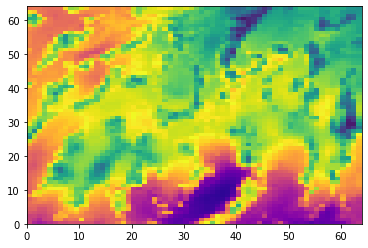

In [19]:
plt.pcolormesh(temp_data['batch'][99, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)

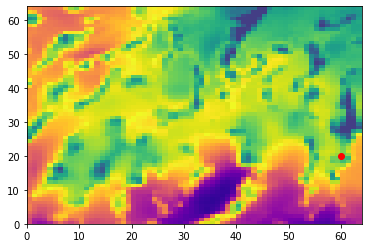

In [20]:
plt.pcolormesh(out[99, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)
plt.plot(60, 20, 'ro')

In [19]:
out[99, 60, 20, 0]

0.063287795

In [23]:
temp_data = np.load(trainfiles[0], allow_pickle=True)[()]

In [24]:
out = model.predict(temp_data['batch'][..., input_flag])

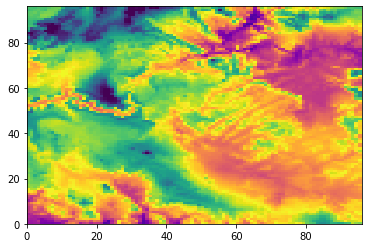

In [33]:
plt.pcolormesh(temp_data['batch'][99, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)

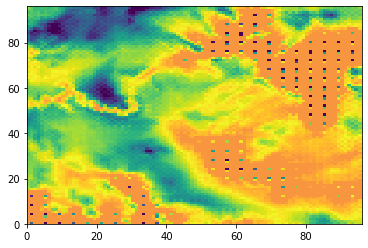

In [34]:
plt.pcolormesh(out[99, ..., 0], vmin=-3, vmax=3, cmap=camp_t2)